In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
!ls predict-ai-model-runtime/npz_all/npz/layout/xla/default/train | head -n 40

/bin/bash: /home/ireyes/anaconda3/envs/kaggle/lib/libtinfo.so.6: no version information available (required by /bin/bash)
alexnet_train_batch_32.npz
bert_classifier.2x2.fp32.npz
bert_classifier.2x2.fp32.performance.npz
bert_pretraining.2x2.fp16.npz
bert_pretraining.8x16.fp16.npz
bert_pretraining.8x8.fp32.performance.npz
bert_squad.2x2.fp32.npz
brax_es.npz
efficientnet_b7_eval_batch_1.npz
inception_v2_batch_128_train.npz
inception_v2_batch_8_train.npz
inception_v3_batch_8_train.npz
inference_mlperf_resnet_batch_16.npz
inference_mlperf_resnet_batch_256.npz
inference_mlperf_ssd_1200_batch_128.npz
inference_mlperf_ssd_1200_batch_1.npz
inference_mlperf_ssd_1200_batch_2.npz
magenta_dynamic.npz
magenta.npz
mask_rcnn_batch_16_bf16_img1024.npz
mask_rcnn_batch_4_bf16_img1408.npz
mask_rcnn_resnet50.4x4.bf16.performance.npz
mlperf_nmt_batch_64.npz
mlperf_resnet_batch_128_1_shard.npz
mlperf_resnet.npz
mlperf_ssd_1_shard_batch_8_fast_epoch.npz
mlperf_ssd_2_shard_batch_8_fast_epoch.npz
mlperf_transfo

In [166]:
layout_dict = dict(np.load("predict-ai-model-runtime/npz_all/npz/layout/xla/default/train/bert_classifier.2x2.fp32.performance.npz"))

In [167]:
for k, v in layout_dict.items():
    print(k)
    print(v.shape)

edge_index
(36659, 2)
node_feat
(20665, 140)
node_opcode
(20665,)
node_config_feat
(22496, 1143, 18)
node_config_ids
(1143,)
node_splits
(1, 2)
config_runtime
(22496,)


In [168]:
for k, v in layout_dict.items():
    print(k)
    print(v.shape)

edge_index
(36659, 2)
node_feat
(20665, 140)
node_opcode
(20665,)
node_config_feat
(22496, 1143, 18)
node_config_ids
(1143,)
node_splits
(1, 2)
config_runtime
(22496,)


In [2]:
layer_map = {}
with open('layer_map.txt', 'r') as f:
    for line in f:
        layer_name, code = line[2:-2].rstrip(' ')[:-1].split(', ')
        layer_name = layer_name.strip('"')
        layer_map[code] = layer_name

In [3]:
for layer, count in zip(*np.unique(layout_dict['node_opcode'], return_counts=True)):
    print(layer_map[str(layer)], count)

NameError: name 'layout_dict' is not defined

In [171]:
idx = np.random.randint(len(layout_dict['edge_index']), size=15)
for edge in layout_dict['edge_index'][idx]:
    edge_to, edge_from = edge
    print(
        layer_map[str(layout_dict['node_opcode'][edge_from])], 
        '->',
        layer_map[str(layout_dict['node_opcode'][edge_to])]
    )

constant -> subtract
or -> xor
add -> tuple
multiply -> multiply
add -> add
multiply -> add
parameter -> get-tuple-element
add -> select
xor -> shift-right-logical
broadcast -> select
xor -> shift-left
add -> xor
xor -> shift-right-logical
or -> xor
slice -> shift-right-logical


In [172]:
n_nodes = len(layout_dict['node_opcode'])
adjacency_matrix = np.zeros((n_nodes, n_nodes), dtype=int)
for edge in layout_dict['edge_index']:
    edge_to, edge_from = edge
    adjacency_matrix[edge_to, edge_from] += 1

print(adjacency_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]]


In [173]:
adjacency_matrix.shape

(20665, 20665)

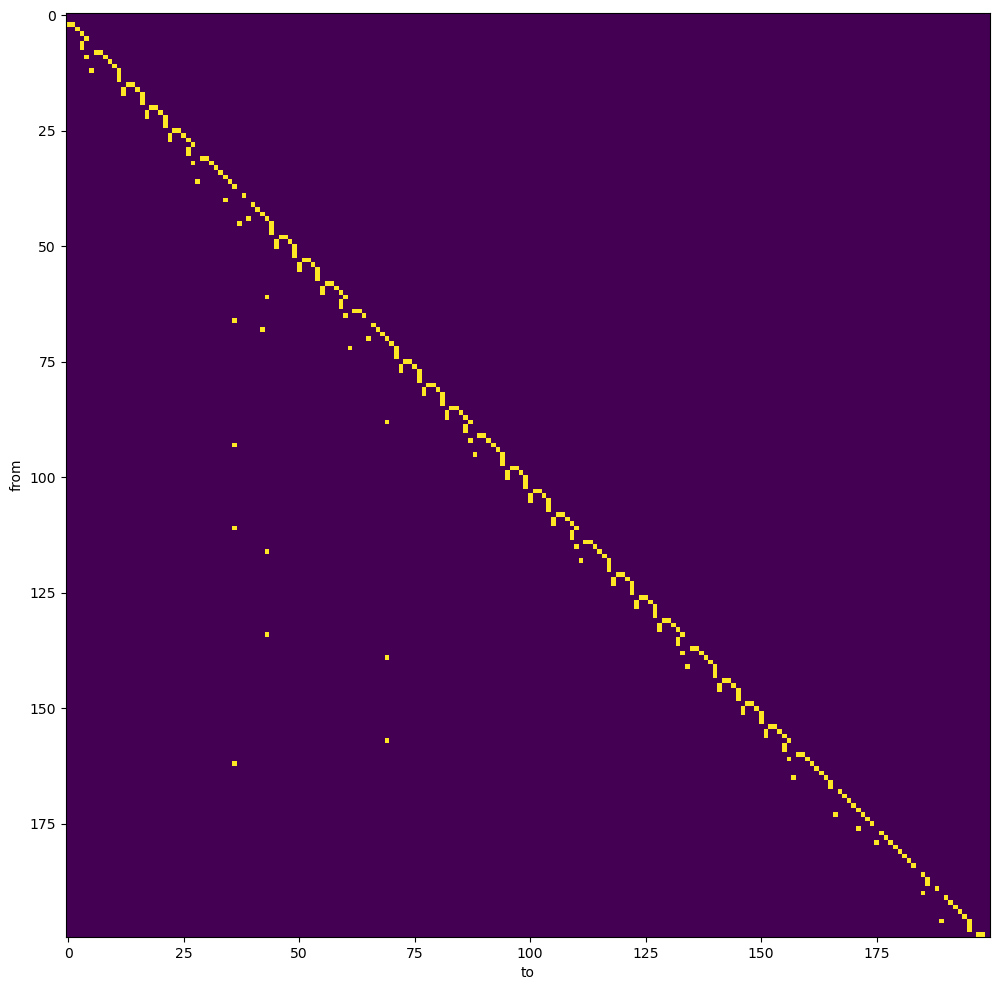

In [174]:
plt.figure(figsize=(12, 12))
offset = 4_000
plt.imshow(adjacency_matrix[offset:offset+200, offset:offset+200])
plt.xlabel('to')
plt.ylabel('from');

In [175]:
for config_id in layout_dict['node_config_ids']:
    parent_indexes = adjacency_matrix[config_id, :].nonzero()[0]
    if len(parent_indexes) > 2:
        print(config_id, layer_map[str(layout_dict['node_opcode'][config_id])])
        print(parent_indexes)

In [176]:
layout_dict['node_config_ids'].shape, layout_dict['node_config_feat'].shape

((1143,), (22496, 1143, 18))

In [177]:
layout_dict['node_config_feat'][3, 100, :].reshape(3, 6)

array([[-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.]], dtype=float32)

// 0–5: Physical layout of the output tensor

0: output_layout_0

1: output_layout_1

2: output_layout_2

3: output_layout_3

4: output_layout_4

5: output_layout_5

// 6-11: Physical layout of the input  tensor

6: intput_layout_0

7: intput_layout_1

8: intput_layout_2

9: intput_layout_3

10: intput_layout_4

11: intput_layout_5

// 12-17: Physical layout of the kernel tensor, only for a convolution operation

12: kernel_layout_0

13: kernel_layout_1

14: kernel_layout_2

15: kernel_layout_3

16: kernel_layout_4

17: kernel_layout_5

[]

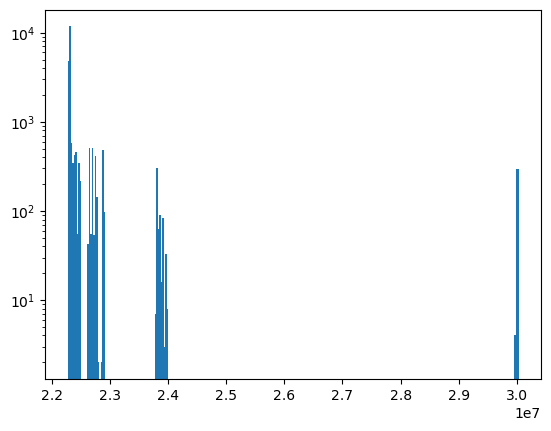

In [178]:
plt.hist(np.clip(layout_dict['config_runtime'], a_min=0, a_max=1.23e12), bins=300);
plt.semilogy()

In [179]:
layout_dict['config_runtime'].shape

(22496,)

In [180]:
node = 300
node_type = layer_map[str(layout_dict['node_opcode'][layout_dict['node_config_ids'][node]])]
layout_dict['node_config_feat'][0, node, :].reshape(3, 6), node_type

(array([[-1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.]], dtype=float32),
 'reshape')

In [26]:
for local_config_index in range(len(layout_dict['node_config_ids'])):
    global_config_index = layout_dict['node_config_ids'][local_config_index]
    node_opcode = layout_dict['node_opcode'][global_config_index]
    node_type = layer_map[str(node_opcode)]
    parent_global_indexes = adjacency_matrix[global_config_index, :].nonzero()[0]
    print('\n', node_type)

    for parent_index in parent_global_indexes:
        global_config_index = parent_index
        print(layout_dict['node_feat'][global_config_index, 21:27])
        node_opcode = layout_dict['node_opcode'][global_config_index]
        node_type = layer_map[str(node_opcode)]
        print(parent_index in layout_dict['node_config_ids'], node_type)



 reshape
[1. 0. 0. 0. 0. 0.]
False slice

 reshape
[0. 0. 0. 0. 0. 0.]
False add

 reshape
[1. 0. 0. 0. 0. 0.]
False slice

 reshape
[1. 0. 0. 0. 0. 0.]
False slice

 reshape
[0. 0. 0. 0. 0. 0.]
False add

 reshape
[0. 0. 0. 0. 0. 0.]
False select

 reshape
[1. 0. 0. 0. 0. 0.]
False slice

 reshape
[0. 0. 0. 0. 0. 0.]
False select

 reshape
[0. 0. 0. 0. 0. 0.]
False get-tuple-element

 reshape
[1. 0. 0. 0. 0. 0.]
False slice

 reshape
[0. 0. 0. 0. 0. 0.]
False shift-right-logical

 reshape
[1. 0. 0. 0. 0. 0.]
False slice

 reshape
[0. 0. 0. 0. 0. 0.]
False xor

 reshape
[1. 0. 0. 0. 0. 0.]
False shift-left

 reshape
[0. 0. 0. 0. 0. 0.]
False shift-right-logical

 reshape
[1. 0. 0. 0. 0. 0.]
False or

 reshape
[0. 0. 0. 0. 0. 0.]
False xor

 reshape
[1. 0. 0. 0. 0. 0.]
False or

 reshape
[1. 0. 0. 0. 0. 0.]
False or

 reshape
[2. 1. 0. 0. 0. 0.]
False concatenate

 reshape
[1. 0. 0. 0. 0. 0.]
False slice

 reshape
[0. 0. 0. 0. 0. 0.]
False or

 reshape
[0. 0. 0. 0. 0. 0.]
False shift-l

# .npz Structures
## Tile .npz files

Suppose a .npz file stores a graph (representing a kernel) with n nodes and m edges. In addition, suppose we compile the graph with c different configurations, and run each on a TPU. Crucially, the configuration is at the graph-level. Then, the .npz file stores the following dictionary (can be loaded with d = dict(np.load("npz/tile/xla/train/<pick_1>.npz"))):

* Key "node_feat": contains float32 matrix with shape (n, 140). The uth row contains the feature vector for node u < n (please see Subsection "Node Features"). Nodes are ordered topologically.
* Key "node_opcode" contains int32 vector with shape (n, ). The uth entry stores the op-code for node u (please see the mapping of opcode to instruction's name here).
* Key "edge_index" contains int32 matrix with shape (m, 2). If entry i is = [u, v] (where 0 <= u, v < n), then there is a directed edge from node u to node v, where u consumes the output of v.
* Key "config_feat" contains float32 matrix with shape (c, 24) with row j containing the (graph-level) configuration feature vector (please see Subsection "Tile Config Features").
* Keys "config_runtime" and "config_runtime_normalizers": both are int64 vectors of length c. Entry j stores the runtime (in nanoseconds) of the given graph compiled with configuration j and a default configuration, respectively. Samples from the same graph may have slightly different "config_runtime_normalizers" because they are measured from different runs on multiple machines.

Finally, for the tile collection, your job is to predict the indices of the best configurations (i.e., ones leading to the smallest d["config_runtime"] / d["config_runtime_normalizers"]).
## Layout .npz files

Suppose a .npz file stores a graph (representing the entire program) with n nodes and m edges. In addition, suppose we compile the graph with c different configurations, and run each on a TPU. Crucially, the configuration is at the node-level. Suppose that nc of the n nodes are configurable. Then, the .npz file stores the following dictionary (can be loaded with, e.g., d = dict(np.load("npz/layout/xla/random/train/<pick_1>.npz"))):

* Keys "node_feat", "node_opcode", "edge_index", are like above.
* Key "node_config_ids" contains int32 vector with shape (nc, ) and every entry is in {0, 1, ..., n - 1} i.e. indicating the indices of the configurable nodes. For these nodes, they can have an additional feature vector that instructs the compiler (described next).
* Key "node_config_feat" contains float32 tensor with shape (c, nc, 18). Entry [j, k] gives an 18-dimensional vector describing the configuration features for node d["node_config_ids"][k] for the jth run (please see Subsection "Layout Config Features").
* Key "config_runtime" contains int32 vector with shape (c, ) where the jth entry contains the runtime of the jth run (i.e., when nodes are configured with d["node_config_feat"][j]).

Finally, for the layout collections, your job is to predict the order of the indices from best-to-worse configurations (i.e., ones leading to the smallest d["config_runtime"]). We do not have to use runtime normalizers for this task because the runtime variation at the entire program level is very small.

Optionally, you may access key "node_splits", which is a variable-length list of node IDs that are the starting of HLO computations in the graph (similar to functions in a program). Essentially, nodes d["node_splits"][i] to d["node_splits"][i+1] - 1 belongs to the same computation. If you want to partition the graph into multiple segments, this information may be useful, e.g., putting nodes from the same computation in the same partition. However, you may compute your own partitioning (e.g., using METIS) as well.


In [4]:
!ls predict-ai-model-runtime/npz_all/npz/tile/xla/train

alexnet_train_batch_32_11d55dfd21d1a19c.npz
alexnet_train_batch_32_-1bae27a41d70f4dc.npz
alexnet_train_batch_32_1cc5935062f109b3.npz
alexnet_train_batch_32_21b74c4dba464305.npz
alexnet_train_batch_32_-21d9f3b8c41eb3e3.npz
alexnet_train_batch_32_24aa8731e7561309.npz
alexnet_train_batch_32_-282ddd3271de7d28.npz
alexnet_train_batch_32_2db921cb9795b9f5.npz
alexnet_train_batch_32_-3545610a073feea6.npz
alexnet_train_batch_32_-444744203bcb5069.npz
alexnet_train_batch_32_449f560eb28987c8.npz
alexnet_train_batch_32_45bf92e4b4071319.npz
alexnet_train_batch_32_47d47dec2b3855a0.npz
alexnet_train_batch_32_491305b51ef1cabb.npz
alexnet_train_batch_32_4ae805e53b8d2b8a.npz
alexnet_train_batch_32_5114fe64ffb1adbb.npz
alexnet_train_batch_32_5385ab3df33a9cce.npz
alexnet_train_batch_32_5484a5e4e39f44b1.npz
alexnet_train_batch_32_579e7b2c540f0929.npz
alexnet_train_batch_32_-5db461c5a6356391.npz
alexnet_train_batch_32_-62a1b4c782bd46c7.npz
alexnet_train_batch_32_6506960125603509.npz
alexnet_train_batch_32_-7

In [ ]:
tile:xla:unet_3d

In [24]:
tile_dict = dict(np.load("predict-ai-model-runtime/npz_all/npz/tile/xla/train/bert_squad.2x2.fp32_-1e604b845afe164c.npz"))

In [25]:
for k, v in tile_dict.items():
    print(k, v.shape)

node_feat (19, 140)
node_opcode (19,)
edge_index (18, 2)
config_feat (37, 24)
config_runtime (37,)
config_runtime_normalizers (37,)


// 0–7: Tile sizes of the convolution kernel, only for a convolution operation.

0: kernel_bounds_0

1: kernel_bounds_1

2: kernel_bounds_2

3: kernel_bounds_3

4: kernel_bounds_4

5: kernel_bounds_5

6: kernel_bounds_sum

7: kernel_bounds_product

// 8–15: Output tile sizes.

8: output_bounds_0

9: output_bounds_1

10: output_bounds_2

11: output_bounds_3

12: output_bounds_4

13: output_bounds_5

14: output_bounds_sum

15: output_bounds_product

// 16-23: Input tile sizes.

16: input_bounds_0

17: input_bounds_1

18: input_bounds_2

19: input_bounds_3

20: input_bounds_4

21: input_bounds_5

22: input_bounds_sum

23: input_bounds_product

In [26]:
tile_dict['config_feat'][10, :].reshape(3, 8)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 96.,   8.,   0.,   0.,   0.,   0., 104., 768.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)

In [27]:
for t, nt in zip(tile_dict['config_runtime'], tile_dict['config_runtime_normalizers']):
    print(t, nt)

70554 70554
73701 70554
85761 70554
70607 70607
108604 70607
95870 70607
83815 70607
70970 70970
73365 70970
97001 70970
81822 70970
70865 70865
84137 70865
94471 70865
71051 70865
70514 70514
70458 70514
70497 70514
72705 70514
70468 70468
82890 70468
70095 70468
93992 70468
70544 70544
71625 70544
73374 70544
87825 70544
70552 70552
71532 70552
70464 70552
88420 70552
70834 70834
84485 70834
72090 70834
70778 70778
94341 70778
71142 70778


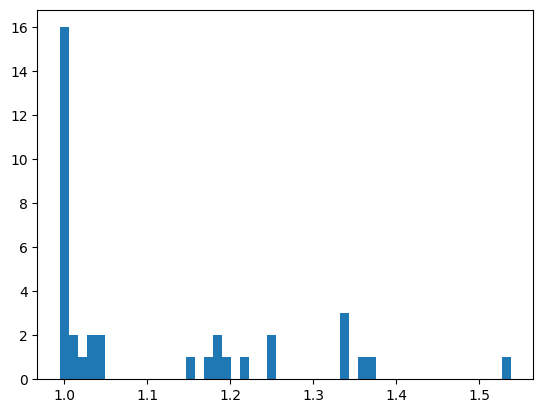

In [28]:
plt.hist(tile_dict['config_runtime']/tile_dict['config_runtime_normalizers'], bins=50);

## Correlation with runtime: tile

In [29]:
norm_cost = tile_dict['config_runtime']/tile_dict['config_runtime_normalizers']
# norm_cost = np.log(norm_cost)
tile_dict['config_feat'].shape, norm_cost.shape

((37, 24), (37,))

In [30]:
np.log(norm_cost.min())

-0.005307241244394599

In [31]:
interesting_indexes = np.arange(24)[
    (np.std(tile_dict['config_feat'], axis=0) != 0.0) 
    & (tile_dict['config_feat'].sum(axis=0) != 0.0)]
interesting_indexes.shape

(4,)

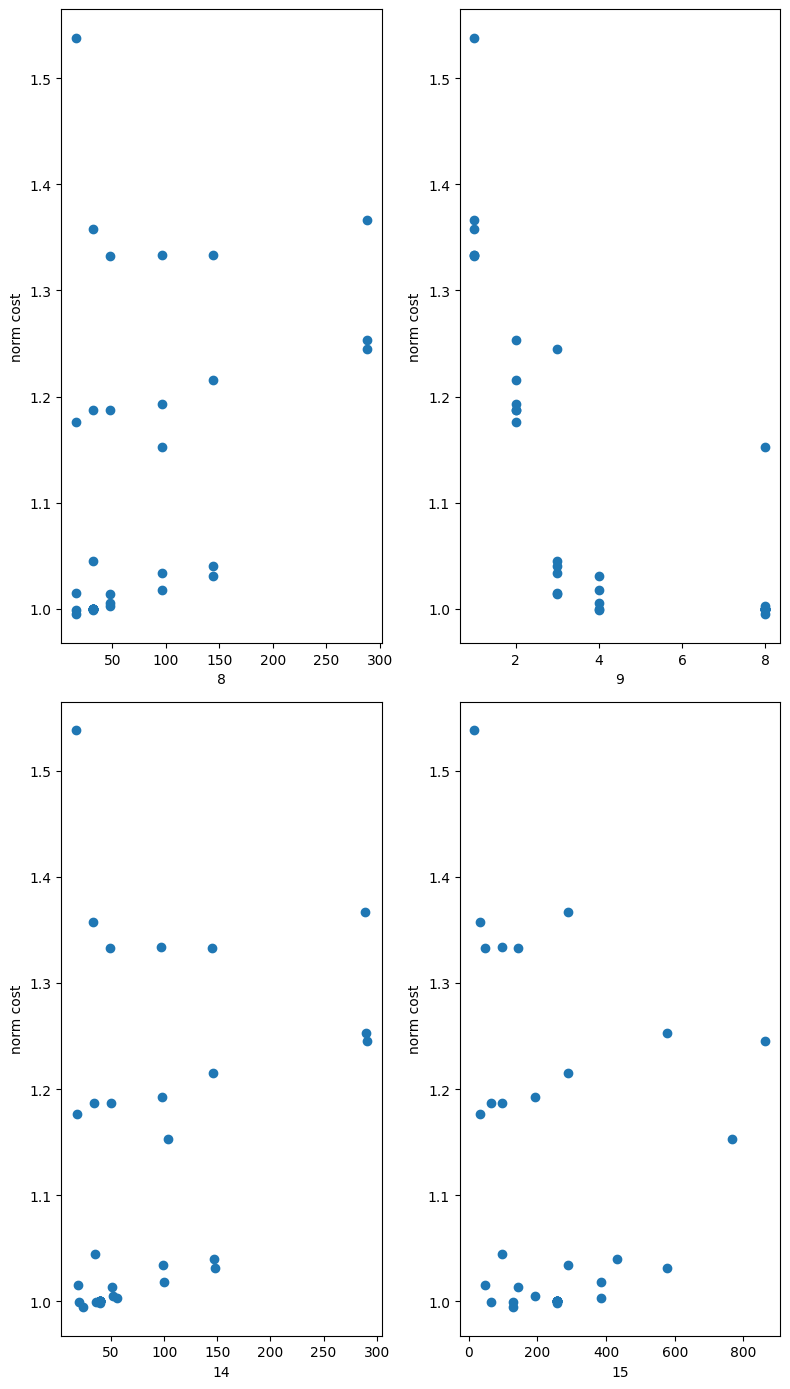

In [32]:
plt.figure(figsize=(8, 14))
for scat_idx, index in enumerate(interesting_indexes):
    plt.subplot(int(np.ceil(len(interesting_indexes) / 2)), 2, scat_idx+1)
    plt.scatter(
        tile_dict['config_feat'][:, index],
        norm_cost
    )
    plt.xlabel(f'{index}')
    plt.ylabel(f'norm cost')
plt.tight_layout()

In [33]:
n_nodes = len(tile_dict['node_opcode'])
adjacency_matrix = np.zeros((n_nodes, n_nodes), dtype=int)
for edge in tile_dict['edge_index']:
    edge_to, edge_from = edge
    adjacency_matrix[edge_to, edge_from] = 1

print(adjacency_matrix)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]]


In [34]:
adjacency_matrix.shape

(19, 19)

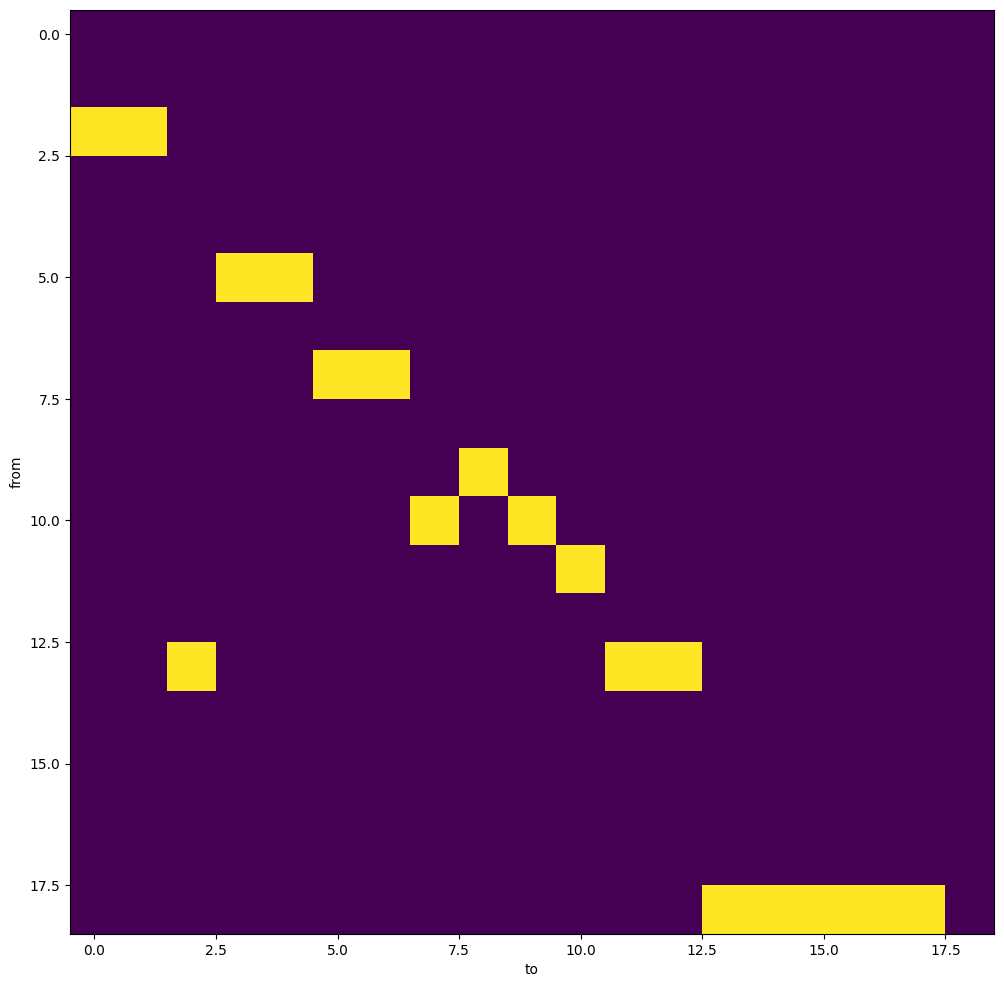

In [35]:
plt.figure(figsize=(12, 12))
plt.imshow(adjacency_matrix)
plt.xlabel('to')
plt.ylabel('from');

In [36]:
for layer, count in zip(*np.unique(tile_dict['node_opcode'], return_counts=True)):
    print(layer_map[str(layer)], count)

add 3
broadcast 1
constant 1
fusion 1
multiply 1
parameter 10
reduce 1
subtract 1


In [37]:
for node_idx, opcode in enumerate(tile_dict['node_opcode']):
    interesting_ops = [
        'multiply',
        'convolution',
        'broadcast'
    ]
    opname = layer_map[str(opcode)] 
    if opname in interesting_ops:
        print(node_idx, opname)

9 broadcast
11 multiply


In [38]:
tile_dict['config_feat'][0].reshape(-1, 8)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 32.,   8.,   0.,   0.,   0.,   0.,  40., 256.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)

## Correlation with runtime: layout

In [27]:
for k, v in layout_dict.items():
    print(k, v.shape)

edge_index (37236, 2)
node_feat (21335, 140)
node_opcode (21335,)
node_config_feat (19232, 1142, 18)
node_config_ids (1142,)
node_splits (1, 2)
config_runtime (19232,)


Configurable layers

In [28]:
[layer_map[str(i)] for i in layout_dict['node_opcode'][layout_dict['node_config_ids']]]

['reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 'reshape',
 're

Parents

In [29]:
for node_config_index in layout_dict['node_config_ids']:
    print([layer_map[str(i)] for i in layout_dict['node_opcode'][adjacency_matrix[node_config_index, :].nonzero()[0]]])

['slice']
['add']
['slice']
['slice']
['add']
['select']
['slice']
['select']
['get-tuple-element']
['slice']
['shift-right-logical']
['slice']
['xor']
['shift-left']
['shift-right-logical']
['or']
['xor']
['or']
['or']
['concatenate']
['slice']
['or']
['shift-left']
['slice']
['shift-right-logical']
['slice']
['xor']
['shift-left']
['shift-right-logical']
['or']
['xor']
['or']
['or']
['concatenate']
['slice']
['or']
['shift-left']
['slice']
['shift-right-logical']
['slice']
['xor']
['shift-left']
['shift-right-logical']
['or']
['xor']
['or']
['or']
['concatenate']
['slice']
['or']
['shift-left']
['slice']
['shift-right-logical']
['slice']
['xor']
['shift-left']
['shift-right-logical']
['or']
['xor']
['or']
['or']
['concatenate']
['slice']
['or']
['shift-left']
['slice']
['shift-right-logical']
['slice']
['xor']
['shift-left']
['shift-right-logical']
['or']
['xor']
['or']
['or']
['concatenate']
['slice']
['or']
['shift-left']
['slice']
['shift-right-logical']
['slice']
['xor']
['shift-

In [31]:
local_selected_configurable_node_id = 340
global_selected_configurable_node_id = layout_dict['node_config_ids'][local_selected_configurable_node_id]
some_trial = 120
print('node configuration')
print(layout_dict['node_config_feat'][some_trial, local_selected_configurable_node_id, :].reshape(3, 6))
layout_dict['node_feat'][global_selected_configurable_node_id, :]

node configuration
[[ 2.  1. -1. -1. -1. -1.]
 [ 1.  3. -1. -1. -1. -1.]
 [ 1.  2. -1. -1. -1. -1.]]


array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 1.600000e+01, 1.280000e+02, 7.680000e+02,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 9.120000e+02,
       1.572864e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.000000e+00, 0.000000e+00, 0.000000e+00, 0.0000

In [32]:
clipped_time = np.clip(layout_dict['config_runtime'], a_min=0.0, a_max=np.percentile(layout_dict['config_runtime'], 50))

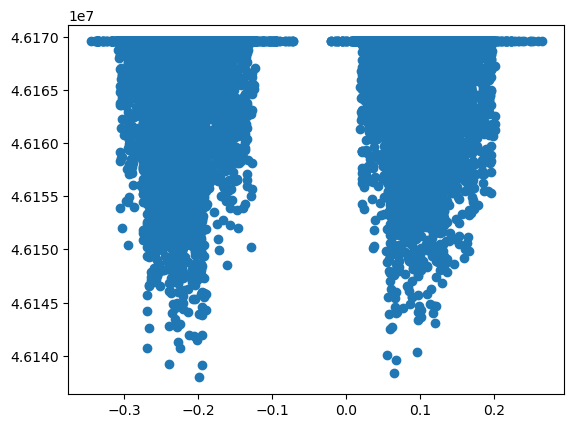

In [33]:
plt.scatter(
    np.mean(layout_dict['node_config_feat'][:, :, 0], axis=(1,)),
    clipped_time
)

In [38]:
layout_dict['node_config_feat'][2, 300:310, [0, 1, 6, 7, 12, 13]]

array([[ 1.,  3.,  1.,  2.,  2.,  2.,  2., -1., -1., -1.],
       [ 3.,  2.,  3.,  3.,  1.,  1.,  1., -1., -1., -1.],
       [ 2.,  3.,  2.,  3.,  1.,  2.,  2., -1., -1., -1.],
       [ 1.,  1.,  1.,  2.,  3.,  1.,  1., -1., -1., -1.],
       [ 0.,  1.,  0.,  1.,  2.,  1.,  1., -1., -1., -1.],
       [ 2.,  3.,  2.,  3.,  1.,  0.,  0., -1., -1., -1.]], dtype=float32)

In [29]:
config_feat = layout_dict['node_config_feat']
random_sample = np.random.choice(np.arange(len(config_feat)), 1000)
config_feat = config_feat[random_sample]
n_equals = (config_feat[:, :, 0] == config_feat[:, :, 6]).astype(int).sum(axis=-1)
conv_max = (config_feat[:, :, 12] > config_feat[:, :, 13]).astype(int).sum(axis=-1)

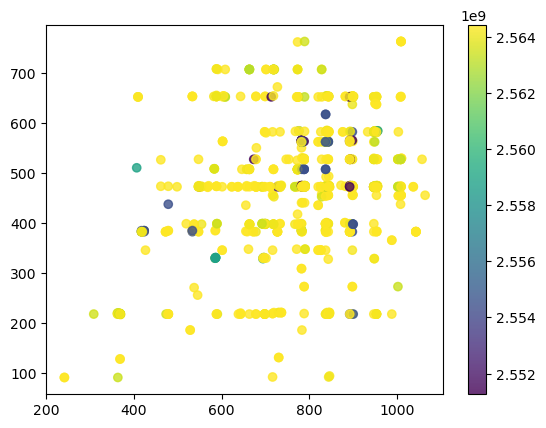

In [30]:
plt.scatter(
    n_equals,
    conv_max,
    #c=layout_dict['config_runtime'][random_sample],
    c=clipped_time[random_sample],
    alpha=0.8
)
plt.colorbar()

In [24]:
layout_dict['node_feat'].shape

(12067, 140)

In [39]:
for k, v in layout_dict.items():
    print(k, v.shape)

edge_index (37236, 2)
node_feat (21335, 140)
node_opcode (21335,)
node_config_feat (19232, 1142, 18)
node_config_ids (1142,)
node_splits (1, 2)
config_runtime (19232,)


In [40]:
node_config_ids = layout_dict['node_config_ids']
node_config_ids.shape

(1142,)

In [42]:
node_config_index_local = 510
node_config_index_global = node_config_ids[node_config_index_local]
node_config_type = layout_dict['node_opcode'][node_config_index_global]
node_config_type_str = layer_map[str(node_config_type)]
print(f'node {node_config_index_global} is {node_config_type_str}')
print(f"number of trials {len(layout_dict['config_runtime'])}")

trial_index = 120
print('output layout, input layout, kernel layout')
print(layout_dict['node_config_feat'][trial_index, node_config_index_local, :].reshape(3, 6))

node_features = layout_dict['node_feat'][node_config_index_global].astype(int)

shape_dims_indexes = np.arange(21, 27)
print('shape dimensions [0-5]\n(e.g. b01c, spatial01-input-output filter dims)')
print('img dims 12 and kernel dims 01 are spatial and dont appear')
print(node_features[shape_dims_indexes], '\n')

shape_dims_indexes = np.arange(31, 37)
print('reshape/broadcast dimensions [0-5]')
print(node_features[shape_dims_indexes])

shape_dims_indexes = np.arange(134, 140)
print('phys layout used to pack tensor minor to major [0-5]')
print(node_features[shape_dims_indexes])

shape_dims_indexes = np.arange(95, 99)
print('conv dims input [0-3]')
print(node_features[shape_dims_indexes])

shape_dims_indexes = np.arange(101, 105)
print('conv dims kernel [0-3]')
print(node_features[shape_dims_indexes])

node 12128 is reshape
number of trials 19232
output layout, input layout, kernel layout
[[ 1.  0. -1. -1. -1. -1.]
 [ 0. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1.]]
shape dimensions [0-5]
(e.g. b01c, spatial01-input-output filter dims)
img dims 12 and kernel dims 01 are spatial and dont appear
[1 1 0 0 0 0] 

reshape/broadcast dimensions [0-5]
[0 0 0 0 0 0]
phys layout used to pack tensor minor to major [0-5]
[1 0 0 0 0 0]
conv dims input [0-3]
[0 0 0 0]
conv dims kernel [0-3]
[0 0 0 0]


In [43]:
parent_indexes = adjacency_matrix[node_config_index_global, :].nonzero()[0]
parent_types_num = [layout_dict['node_opcode'][i] for i in parent_indexes]
parent_types_str = [layer_map[str(i)] for i in parent_types_num]
print(parent_types_str)
for parent_id in parent_indexes:
    print(layout_dict['node_feat'][parent_id, np.arange(21, 27)])
    
print('\n')
for parent_id in parent_indexes:
    print(layout_dict['node_feat'][parent_id, np.arange(134, 140)])
    
print('\n')
for parent_id in parent_indexes:
    print(layout_dict['node_feat'][parent_id, np.arange(31, 37)])

['or']
[1. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0.]


In [44]:
siblings = set()
for parent_id in parent_indexes:
    siblings_indexes = adjacency_matrix[:, parent_id].nonzero()[0]
    siblings.update(siblings_indexes)

siblings.remove(node_config_index_global)
for sibling in siblings:
    is_configurable = sibling in layout_dict['node_config_ids']
    print('\n', sibling, is_configurable)
    print(layer_map[str(layout_dict['node_opcode'][sibling])])
    print(layout_dict['node_feat'][sibling, np.arange(21, 27)].astype(int))
    if is_configurable:
        local_sibling_index = np.where(layout_dict['node_config_ids'] == sibling)[0][0]
        print(layout_dict['node_config_feat'][trial_index, local_sibling_index, :].reshape(3, 6))


 12127 True
reshape
[0 0 0 0 0 0]
[[-1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1.]]


In [29]:
def magic_log(x):
    if x <= 0:
        return -1
    return np.log(x)

magic_log_v = np.vectorize(magic_log)

shapes = layout_dict['node_feat'][sibling, np.arange(21, 27)]
magic_log_v(shapes)

array([ 0.       ,  0.       ,  6.3561077,  5.2574954, -1.       ,
       -1.       ], dtype=float32)

## How many configurable nodes are on each layout graph?

In [93]:
layout_ids = []
layout_sets = []
list_config_nodes = []

for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
        
    layout_set = dirpath.split('/')[-1]
            
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in tqdm(os.listdir(dirpath)):
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        n_config_nodes = len(layout_dict['node_config_ids'])
        layout_ids.append(layout_id)
        layout_sets.append(layout_set)
        list_config_nodes.append(n_config_nodes)
        
df = pd.DataFrame(
    np.stack([layout_ids, layout_sets, list_config_nodes], axis=-1),
    columns=['ID', 'set', 'n_config_nodes']
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]


In [94]:
df['task'] = df['ID'].apply(lambda x: x.split(':')[1])
df

,ID,set,n_config_nodes,task
0,layout:nlp:default:electra_base_batch_size_64_...,train,120,nlp
1,layout:nlp:default:small_bert_bert_en_uncased_...,train,200,nlp
2,layout:nlp:default:bert_en_uncased_L-12_H-768_...,train,120,nlp
3,layout:nlp:default:bert_multi_cased_L-12_H-768...,train,120,nlp
4,layout:nlp:default:experts_wiki_books_batch_si...,train,120,nlp
...,...,...,...,...
634,layout:xla:random:inception_v3_batch_128_train,valid,297,xla
635,layout:xla:random:resnet50.4x4.fp16,valid,166,xla
636,layout:xla:random:resnet_v1_50_official_batch_...,valid,166,xla
637,layout:xla:random:tf2_bert_pretrain_dynamic_ba...,valid,1184,xla


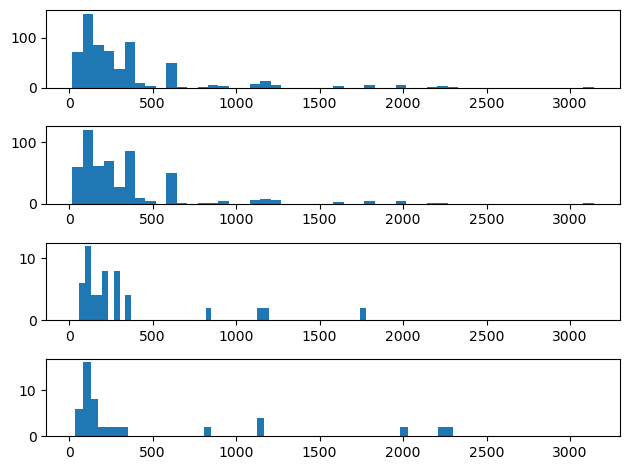

In [95]:
plt.subplot(4, 1, 1)
plt.hist(df['n_config_nodes'].astype(int), bins=50);
xlim = plt.gca().get_xlim()

plt.subplot(4, 1, 2)
plt.hist(df[df['set'] == 'train']['n_config_nodes'].astype(int), bins=50);
plt.gca().set_xlim(xlim)

plt.subplot(4, 1, 3)
plt.hist(df[df['set'] == 'valid']['n_config_nodes'].astype(int), bins=50);
plt.gca().set_xlim(xlim)

plt.subplot(4, 1, 4)
plt.hist(df[df['set'] == 'test']['n_config_nodes'].astype(int), bins=50);
plt.gca().set_xlim(xlim)

plt.tight_layout()

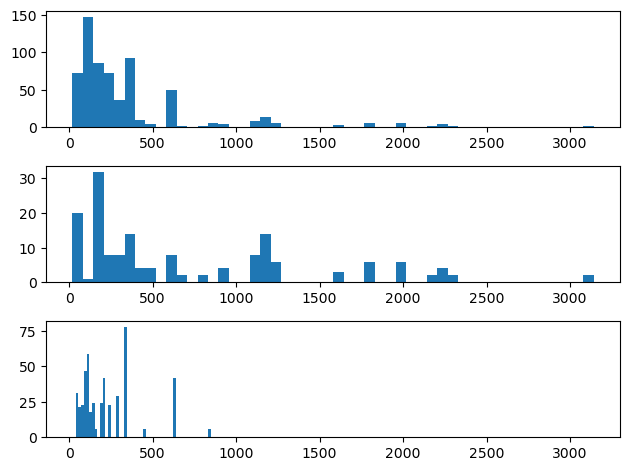

In [96]:
plt.subplot(3, 1, 1)
plt.hist(df['n_config_nodes'].astype(int), bins=50);
xlim = plt.gca().get_xlim()

plt.subplot(3, 1, 2)
plt.hist(df[df['task'] == 'xla']['n_config_nodes'].astype(int), bins=50);
plt.gca().set_xlim(xlim)

plt.subplot(3, 1, 3)
plt.hist(df[df['task'] == 'nlp']['n_config_nodes'].astype(int), bins=50);
plt.gca().set_xlim(xlim)

plt.tight_layout()

In [26]:
df['n_config_nodes'].astype(int).describe()

count     639.000000
mean      358.286385
std       439.671558
min        20.000000
25%       120.000000
50%       216.000000
75%       346.000000
max      3143.000000
Name: n_config_nodes, dtype: float64

In [103]:
df['n_config_nodes'] = df['n_config_nodes'].astype(int)
df.sort_values('n_config_nodes', inplace=True)

In [199]:
df[(df['task'] == 'xla') & (df['n_config_nodes'] > 750)].shape

(59, 4)

In [200]:
59/160

0.36875

## Larger graph, larger time?

In [23]:
graph_sizes = []
average_times = []

for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout/xla/default/train/'):
    if len(filenames) == 0:
        continue
        
    for filename in tqdm(os.listdir(dirpath)):
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        graph_size = len(layout_dict['node_feat'])
        mean_time = np.mean(layout_dict['config_runtime'])
        graph_sizes.append(graph_size)
        average_times.append(mean_time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:27<00:00,  2.25it/s]


In [24]:
graph_sizes = np.array(graph_sizes)
average_times = np.array(average_times)

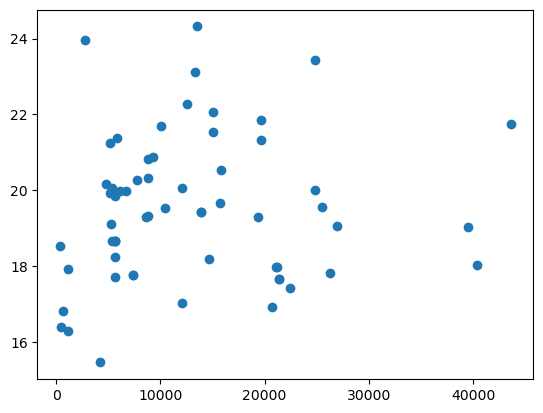

In [25]:
plt.scatter(graph_sizes, np.log(average_times))

In [28]:
np.unique(layout_dict['node_opcode'], return_counts=True)

(array([  2,   4,   5,  12,  13,  19,  20,  24,  25,  26,  31,  32,  34,
         37,  40,  45,  47,  50,  52,  54,  57,  58,  59,  60,  61,  63,
         66,  70,  75,  77,  81,  83,  87,  89,  95,  98, 100, 102, 107],
       dtype=uint8),
 array([ 6177,     2,   711,     6,  1845,     2,    16,   131,  1541,
          818,     3,     2,     3,     1,    49, 10504,     1,     1,
            3,     7,     1,     1, 10901,   166,     1,  3949,     1,
         1262,   337,    49,   874,    22,     4,     6,  3993,     1,
            5,     1,   218]))

In [31]:
layout_dict['node_opcode'].shape

(43615,)

## Dummy reshape nodes?

In [181]:
np.all(layout_dict['node_config_feat'] == -1, axis=(0, 2))

array([False, False, False, ..., False, False, False])

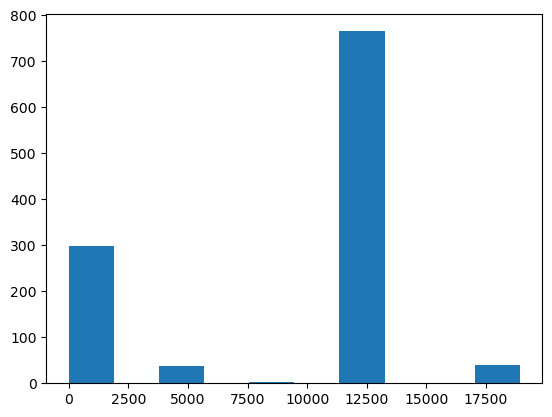

In [182]:
how_many_dummies = np.all(layout_dict['node_config_feat'] == -1, axis=2).sum(axis=0)
plt.hist(how_many_dummies);

In [183]:
static_nodes = np.max(np.std(layout_dict['node_config_feat'], axis=0), axis=1)

In [184]:
np.sum(static_nodes == 0)

0

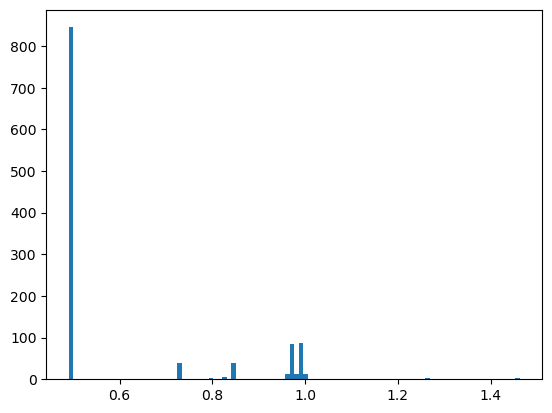

In [185]:
plt.hist(static_nodes, bins=100);

In [128]:
layout_dict['node_config_ids'][1930]

19859

In [129]:
np.argmax(layout_dict['node_config_feat'][:, 1930, 0])

71

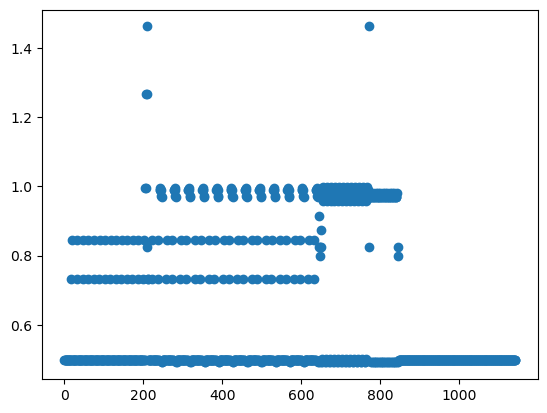

In [186]:
plt.scatter(np.arange(len(how_many_dummies)), np.max(np.std(layout_dict['node_config_feat'], axis=0), axis=1))

In [146]:
layout_dict['config_runtime'].shape

(11560,)

In [140]:
layout_dict['node_config_feat'][:, 0, 0]

array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)

In [133]:
layout_dict['node_config_feat'][71, 1930, :].reshape(3, 6)

array([[ 4.,  2.,  3.,  0.,  1., -1.],
       [ 3.,  1.,  2.,  0., -1., -1.],
       [-1., -1., -1., -1., -1., -1.]], dtype=float32)

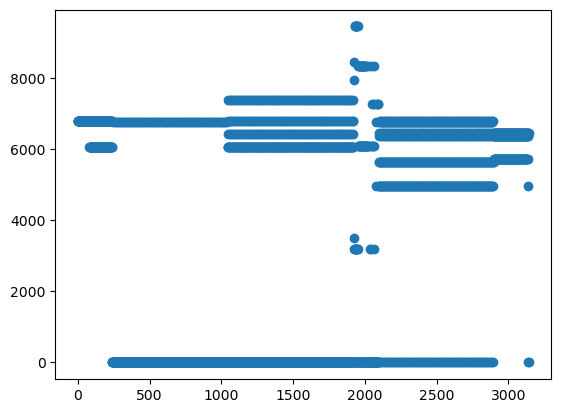

In [136]:
plt.scatter(np.arange(len(how_many_dummies)), how_many_dummies);

In [190]:
np.random.choice(np.arange(5), 3, replace=False, p=[0,0,0,0,1])

ValueError: Fewer non-zero entries in p than size